# Example2: Localization for single events

In this notebook I will show how to localize a GW event with seal.

In [1]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json
from pycbc.filter import matched_filter,matched_filter_core
from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from lal import LIGOTimeGPS

import sealgw
from sealgw import seal
import sealgw.calculation as sealcal
import sealgw.simulation as sealsim

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Case I: Localizing SPIIR trigger events

Seal is going to be implemented in SPIIR, here I show how to process .xml file from SPIIR and localize it.

### Extract information and do it manually

You can extract event information from xml file and provide it to Seal manually. Same function can be used for your own GW events.


In [2]:
# Initialize Seal

seal_O2 = seal.Seal('example_outputs/sealconfig_O2_lhv_BNS.txt') # use the config we fit in example1
xml_filepath = 'example_inputs/H1L1V1_1187008882_3_806.xml'

# extract_info_from_xml returns a lot of useful data that seal needs
# return_names==True: return det names
# return_names==False: return det codes
#  Note here snr_arrays, time_arrays are 1-D arrays, SNR series and timestamps from different detectors are connected to 1-D. 
#  ntimes_array stores the length of each detector, i.e., 
#  the first ntimes_array[0] elements in snr_arrays, is the snr series of 1st detector. Same for timestamps.
#  from ntimes_array[0]+1 to ntimes_array[0]+ntimes_array[1] are elements for 2nd detector.
#  Seal.localize take 1-D array, here is auto-converted when reading xml file. But if you are using your own SNR, remember to convert.
#  See simulation examples below.
trigger_time, ndet, ntimes_array, det_names, max_snr_array, sigma_array, time_arrays, snr_arrays =\
        sealcal.localization.extract_info_from_xml(xml_filepath, return_names=True)

#can be converted with:
#det_codes_array = sealcal.localization.get_det_code_array(det_names)

xml processing done. 
Trigger time: 1187008882.4453125
Detectors: ['H1', 'L1', 'V1']
SNRs: [15.10651112 24.52303505  1.96168923]
sigmas: [1969.1236365  1677.65263077  912.23831788]


In [28]:
nofd = int(len(time_arrays)/3)

In [29]:
t1 = time_arrays[0:nofd]
t2 = time_arrays[nofd:2*nofd]
t3 = time_arrays[2*nofd:]

s1 = snr_arrays[0:nofd]
s2 = snr_arrays[nofd:2*nofd]
s3 = snr_arrays[2*nofd:]

In [35]:
t3[np.argmax(abs(s1))]

1187008882.4267578

In [36]:
t3.mean()

1187008882.4267578

In [47]:
np.average([1187008882.4487305, 1187008882.4453125, 1187008882.4267578], weights=max_snr_array**2)

1187008882.4461627

In [16]:
tccc = 0
for tt in [t1,t2,t3]:
    tccc += (tt[0] + tt[-1])/2
    print((tt[0] + tt[-1])/2)
print(tccc/3)

1187008882.4487305
1187008882.4453125
1187008882.4267578
1187008882.4402668


In [12]:
t1[-1]

1187008882.5341797

In [21]:
import ligo.skymap

In [23]:
from ligo.skymap import io as lsio

In [35]:
Bevent = lsio.events.ligolw.LigoLWEventSource(xml_filepath)

Using anti-FINDCHIRP phase convention; inverting phases. This is currently the default and it is appropriate for gstlal and MBTA but not pycbc as of observing run 1 ("O1"). The default setting is likely to change in the future.


In [25]:
from ligo.skymap import bayestar

In [26]:
event_source = ligo.skymap.io.events.open(
                            xml_filepath
                        , psd_file='/Users/qianhu/Downloads/gstlal_H1L1V1-REFERENCE_PSD-1186624818-687900.xml.gz')

for coinc_event_id, event in event_source.items():
    sky_map_B = ligo.skymap.bayestar.localize(
                                        event,
                                        waveform="o2-uberbank",
                                        prior_distance_power=2,
                                        cosmology=True,
                                        mcmc=False,
                                        chain_dump=False,
                                        enable_snr_series=snr_series,
                                    )

Using anti-FINDCHIRP phase convention; inverting phases. This is currently the default and it is appropriate for gstlal and MBTA but not pycbc as of observing run 1 ("O1"). The default setting is likely to change in the future.


NameError: name 'snr_series' is not defined

In [44]:
event_source.items()

odict_items([(1, <LigoLWEvent(singles=(<LigoLWSingleEvent(detector='H1', snr=15.106511, phase=-1.8731751, time=1187008882.4487305)>, <LigoLWSingleEvent(detector='L1', snr=24.523035, phase=0.85883731, time=1187008882.4453125)>, <LigoLWSingleEvent(detector='V1', snr=1.9616892, phase=-0.72617036, time=1187008882.4267578)>))>)])

In [52]:
i=0
for coinc_event_id, event in event_source.items():
    epoch, sample_rate, toas, snrs, responses, locations, horizons = bayestar.condition(event)
    #print('Det ', i)
    print(epoch)
    print(toas)
    #print(snrs)
    print(horizons)
    
    #tt = [t1,t2,t3][i]
    #print( (tt[0] + tt[-1])/2 + toas - 1187008882)
    i+=1

Truncating PSD at 0.95 of maximum frequency to suppress rolloff artifacts. This option may be removed in the future.
Truncating PSD at 0.95 of maximum frequency to suppress rolloff artifacts. This option may be removed in the future.
Truncating PSD at 0.95 of maximum frequency to suppress rolloff artifacts. This option may be removed in the future.
Template is unspecified; using ER10/O2 uberbank criterion
Assuming PSD is infinite at 0.0078125 Hz because PSD is only sampled down to 0.03125 Hz
Assuming PSD is infinite at 0.0078125 Hz because PSD is only sampled down to 0.03125 Hz
Assuming PSD is infinite at 0.0078125 Hz because PSD is only sampled down to 0.03125 Hz


1187008882.446433024
[-0.0284643  -0.03188216 -0.05043678]
[1160.29658941 1693.41439011  485.4790611 ]


In [3]:
351/2 * 1/2048

0.085693359375

In [39]:
########### Reload some event info because xml has some errors ###########
#trigger_time = 1187008882.43
trigger_time = 1187008882.44
start_time = trigger_time-0.022
end_time = trigger_time+0.022
sigma_array = np.array([142*8.0,213*8.0,60*8.0])
print("Time prior and horizon are manually corrected.")
########### Delete above when xml issues are fixed ###########

Time prior and horizon are manually corrected.


In [17]:
trigger_time

1187008882.44

In [38]:
6400e3/299792458

0.02134810209268173

In [44]:
# localize with seal. If you set timecost=False, it doesn't return timecost.

nthread = 8 # use 8 threads
max_snr = sum(snr**2 for snr in max_snr_array)
max_snr = max_snr**0.5
logprob_skymap, timecost = seal_O2.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True)

print("Timecost (s): ", timecost)

Timecost (s):  0.8267059326171875


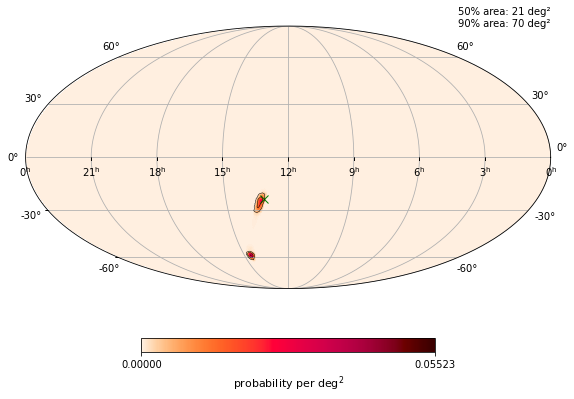

In [45]:
# plot it.
save_filename = 'example_outputs/skymap_GW170817test.pdf'
true_ra = 3.446
true_dec = -0.408
sealcal.localization.plot_skymap(logprob_skymap, save_filename=None, true_ra = true_ra, true_dec = true_dec)

### Let seal do it automatically

The above process can be done by seal. It's convenient to let seal do this inside, but you cannot see what info is stored in xml.

...waiting to fix trigger time and sigma issue in xml...

## Case II: Localizing your simulation events

Seal provides snr_generator to help you generate SNR timeseries (in the format of pycbc timeseries) and sigmas. 

You just need to provide detector, waveform generator, injection parameter (in bilby style), call the snr_generator, and pass the variables. You may need to reshape some variables before passing.

In [6]:
injection_parameters = dict(mass_1 = 1.4, mass_2 = 1.4, chi_1=0.02, chi_2=0.01, lambda_1=425, lambda_2=425,
                            luminosity_distance=100., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=2.1, dec=1.2)

duration = 320. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='TaylorF2', minimum_frequency=20.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
# if your want to use your own PSD
for i in range(len(ifos)):
    det = ifos[i]
    psd_file = psd_files[i]
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
    det.power_spectral_density = psd 

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)



12:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:03 bilby INFO    : Injected signal in H1:
12:03 bilby INFO    :   optimal SNR = 7.22
12:03 bilby INFO    :   matched filter SNR = 6.96-0.25j
12:03 bilby INFO    :   mass_1 = 1.4
12:03 bilby INFO    :   mass_2 = 1.4
12:03 bilby INFO    :   chi_1 = 0.02
12:03 bilby INFO    :   chi_2 = 0.01
12:03 bilby INFO    :   lambda_1 = 425
12:03 bilby INFO    :   lambda_2 = 425
12:03 bilby INFO    :   luminosity_distance = 100.0
12:03 bilby INFO    :   theta_jn = 0.4
12:03 bilby INFO    :   psi = 2.6
12:03 bilby INFO    :   phase = 1.3
12:03 bilby INFO    :   geocent_time = 1126259642.4
12:03 bilby INFO    :   ra = 2.1
12:03 bilby INFO    :   dec = 1.2
12:03 bilby INFO    : Injected signal in L1:
12:03 bilby INFO    :   optimal SNR = 9.38
12:03 bilby 

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -4.10580446e-27-1.16500555e-25j, -4.09971980e-27-1.16500562e-25j,
         -4.09363520e-27-1.16500568e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -1.16107796e-25+4.09196253e-27j, -1.16107803e-25+4.08589838e-27j,
         -1.16107809e-25+4.07983430e-27j])},
 {'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -4.10580446e-27-1.16500555e-25j, -4.09971980e-27-1.16500562e-25j,
         -4.09363520e-27-1.16500568e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -1.16107796e-25+4.09196253e-27j, -1.16107803e-25+4.08589838e-27j,
         -1.16107809e-25+4.07983430e-27j])},


In [7]:
# Generate SNR and sigma
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)

injection tc:  1126259642.4
Max snr time: 1126259642.3863282, SNR = 7.075396981354846


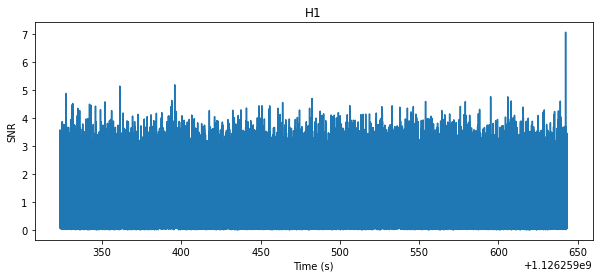

Max snr time: 1126259642.387793, SNR = 8.375158285355012


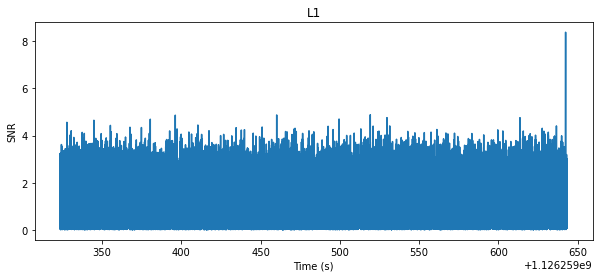

Max snr time: 1126259574.106299, SNR = 4.66154800812293


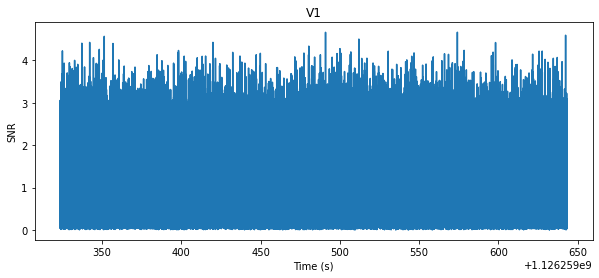

Max network SNR:  11.913628690728565


In [8]:
# Take a look at SNR we have
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('SNR')
    plt.xlabel('Time (s)')
    plt.title(det_names[det_id])
    plt.show()
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

In [9]:

nthread = 8 # use 8 threads

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01

seal_sim = seal.Seal('example_outputs/sealconfig_bilby_lhv_BNS.txt')
logprob_skymap, timecost = seal_sim.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True)

print("Timecost (s): ", timecost)

Timecost (s):  0.8132369518280029


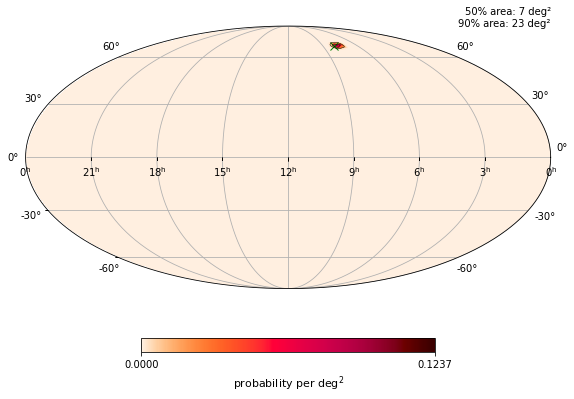

In [10]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

# We don't save skymap this time, just plot
sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec)

In [11]:
# Confidence area
sealcal.localization.confidence_area(logprob_skymap, [50, 90])

array([ 6.91105861, 22.94943561])

In [12]:
# Search area
sealcal.localization.search_area(logprob_skymap, true_ra, true_dec)

2.124462039440766